# Torch review

### Autograd and Backpropagation

- Build a simple linear regression model using PyTorch's autograd
- Compute gradients and update weights manually

In [30]:
import torch
import pandas as pd

wine = pd.read_csv('wine.csv')
wine.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [141]:
wine_std = (wine - wine.mean()) / wine.std()

<Axes: >

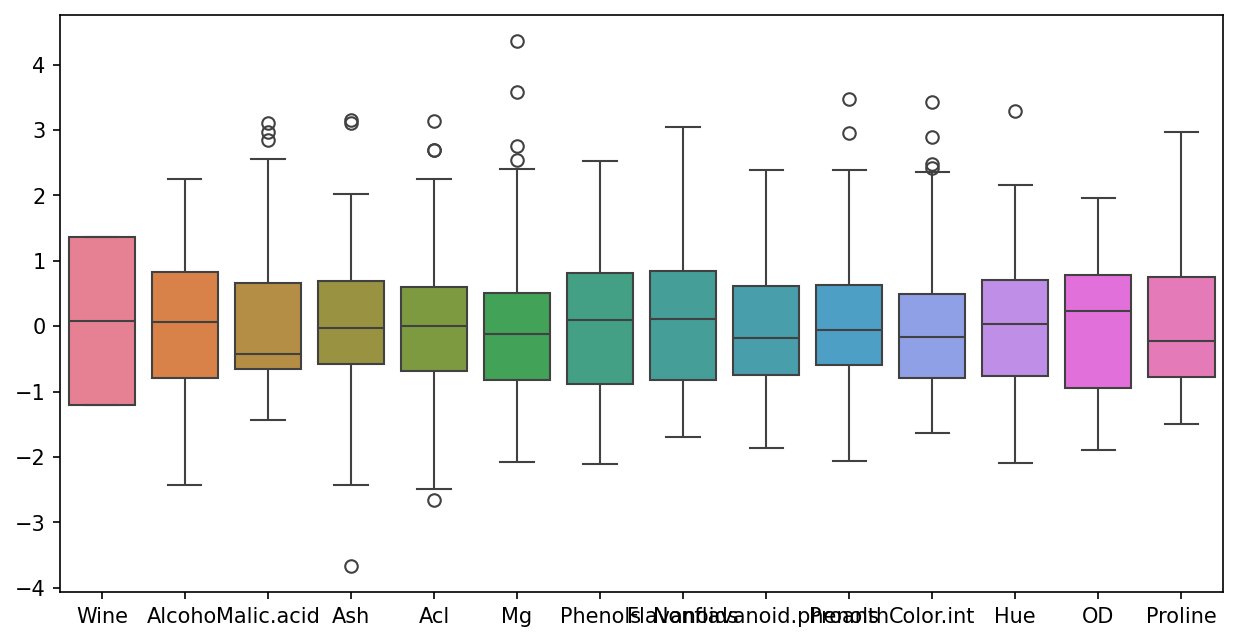

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5), dpi=150)
sns.boxplot(wine_std)

In [146]:
X = torch.tensor(wine_std.drop('Wine', axis=1).values, dtype=torch.float32)
y = torch.tensor(wine['Wine'].values - 1, dtype=torch.int64)
y = torch.nn.functional.one_hot(y).float()

In [147]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.weight = torch.nn.Parameter(torch.randn((input_dim, output_dim), requires_grad=True))
        self.bias = torch.nn.Parameter(torch.randn((1, output_dim), requires_grad=True))

    def forward(self, x):
        logit = torch.matmul(x, self.weight) + self.bias
        return logit

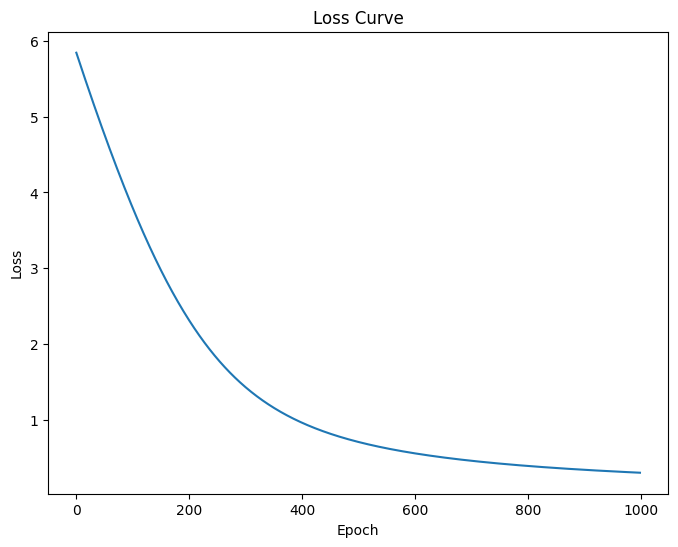

In [148]:
import matplotlib.pyplot as plt

# Instantiate the model
model = LinearRegression(X.shape[1], 3)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Training parameters
learning_rate = 0.005
num_epochs = 1000

# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X)

    # Compute loss
    loss = criterion(y_pred, y)

    # Backpropagation
    loss.backward()

    # Update weights
    with torch.no_grad():
        model.weight.data -= learning_rate * model.weight.grad
        model.bias.data -= learning_rate * model.bias.grad

        # Zero out gradients
        model.weight.grad.zero_()
        model.bias.grad.zero_()

    # Store loss for plotting
    losses.append(loss.item())

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Print the learned weights and bias
#print(f"Learned Weight: {model.weight.item():.3f}")
#print(f"Learned Bias: {model.bias.item():.3f}")

In [149]:
with torch.no_grad():
    y_pred = model(X)
    y_pred = torch.argmax(y_pred, axis=1)
    accuracy = (y_pred == torch.argmax(y, axis=1)).float().mean()
    print(f"Accuracy: {accuracy.item():.3f}")

Accuracy: 0.888


### Neural Network Basics

- Implement a fully connected neural network for a classification task
- Use PyTorch's built-in modules and loss functions

In [157]:
from torch import nn
model = nn.Sequential(
    nn.Linear(X.shape[1], 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 3),
)

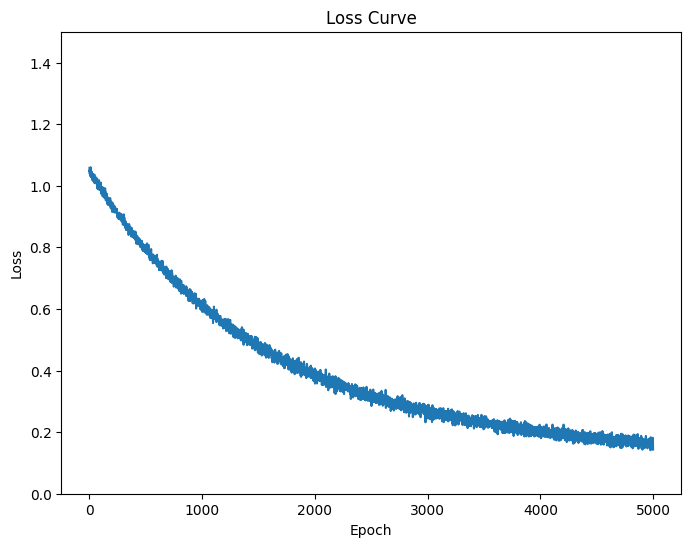

In [158]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training parameters
learning_rate = 0.01
num_epochs = 5000

# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X)

    # Compute loss
    loss = criterion(y_pred, y)

    # Backpropagation
    loss.backward()

    # Update weights
    optimizer.step()

    # Zero out gradients
    optimizer.zero_grad()

    # Store loss for plotting
    losses.append(loss.item())

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1.5)
plt.show()

In [159]:
with torch.no_grad():
    y_pred = model(X)
    y_pred = torch.argmax(y_pred, axis=1)
    accuracy = (y_pred == torch.argmax(y, axis=1)).float().mean()
    print(f"Accuracy: {accuracy.item():.3f}")

Accuracy: 0.983


### Custom Model Classes

- Define a custom PyTorch module for a specific architecture (e.g., ResNet, Transformer)
- Implement forward pass, initializer, and other custom methods

In [242]:
class AutoEncoder(nn.Module):
    def __init__(self, dim_in, dim_out) -> None:
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(dim_in, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, dim_in),
        )

        self.linear = nn.Linear(dim_in, dim_out)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        out = self.linear(decoded)
        return encoded, decoded, out

In [243]:
import torch.nn.functional as F

def custom_loss(X, labels, autoencoder, alpha=0.5):

    _, reconstructed, outputs = autoencoder(X)
    ce_loss = F.cross_entropy(outputs, labels)
    recon_loss = F.mse_loss(reconstructed, X)
    
    # Combine the losses using a weighted sum
    loss = alpha * ce_loss + (1 - alpha) * recon_loss
    
    return loss

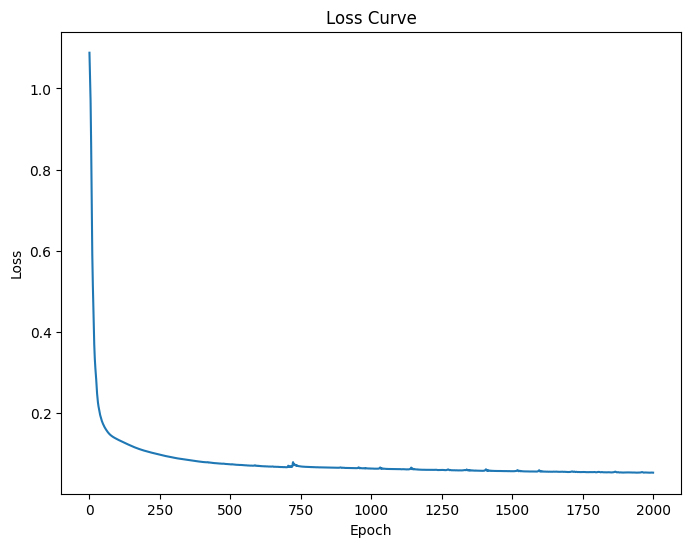

In [245]:
model = AutoEncoder(X.shape[1], 3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training parameters
num_epochs = 2000

# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    X_reduced, X_reconstructed, y_pred = model(X)

    # Compute loss
    loss = custom_loss(X, y, model, alpha=0.7)

    # Backpropagation
    loss.backward()

    # Update weights
    optimizer.step()

    # Zero out gradients
    optimizer.zero_grad()

    # Store loss for plotting
    losses.append(loss.item())

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [246]:
with torch.no_grad():
    X_red, X_rec, y_pred = model(X)
    y_pred = torch.argmax(y_pred, axis=1)
    accuracy = (y_pred == torch.argmax(y, axis=1)).float().mean()
    print(f"Accuracy: {accuracy.item():.3f}")

Accuracy: 1.000


<Axes: xlabel='None', ylabel='None'>

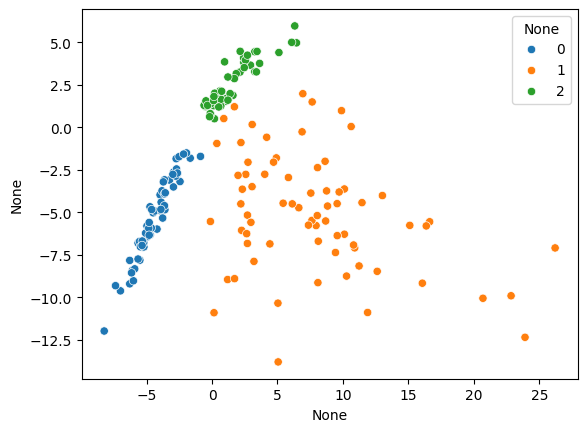

In [247]:
sns.scatterplot(x=X_red[:, 0], y=X_red[:, 1], hue=y_pred, palette='tab10')

### Custom Training Loops

- Implement a custom training loop for a neural network model
- Incorporate features like learning rate scheduling and early stopping

In [265]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [266]:
def evaluate():
    with torch.no_grad():
        _, X_rec, y_pred = model(X_test)
        rec_loss = F.mse_loss(X_rec, X_test)
        y_pred = torch.argmax(y_pred, axis=1)
        accuracy = (y_pred == torch.argmax(y_test, axis=1)).float().mean()
        return accuracy.item(), rec_loss.item()

In [267]:
class EvaluationCallback:
    def __init__(self, evaluation_interval):
        self.evaluation_interval = evaluation_interval

    def __call__(self, epoch):
        if epoch % self.evaluation_interval == 0:
            metrics = evaluate()
            print(f"Epoch {epoch}: {metrics}")

class EarlyStoppingCallback:
    def __init__(self, patience):
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True  # Stop training

class LearningRateCallback:
    def __init__(self, lr_decay_factor):
        self.lr_decay_factor = lr_decay_factor

    def __call__(self, epoch):
        new_lr = optimizer.param_groups[0]['lr'] * self.lr_decay_factor
        optimizer.param_groups[0]['lr'] = new_lr

Epoch 0: (0.6111111044883728, 0.8842443227767944)
Epoch 100: (1.0, 0.3757875859737396)
Epoch 200: (1.0, 0.3371827006340027)
Epoch 300: (1.0, 0.33404815196990967)
Epoch 400: (1.0, 0.34229519963264465)


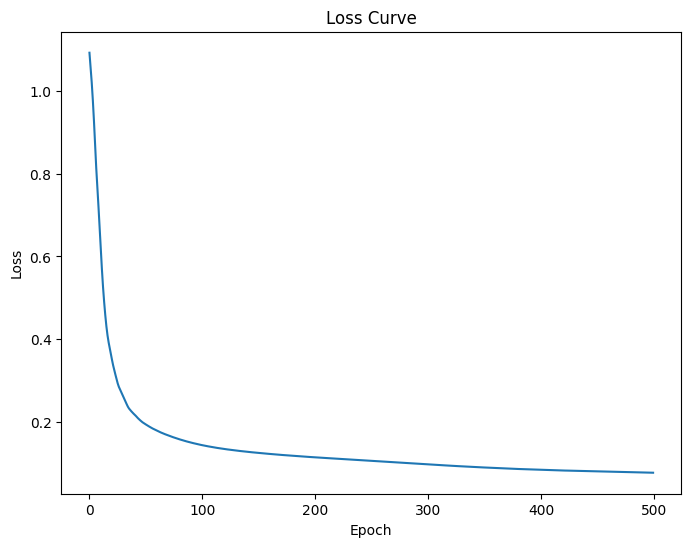

In [290]:
model = AutoEncoder(X.shape[1], 3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500
evaluation_interval = 100
patience = 5
lr_decay_factor = 0.999

# Create instances of the callbacks
evaluation_callback = EvaluationCallback(evaluation_interval)
early_stopping_callback = EarlyStoppingCallback(patience)
lr_callback = LearningRateCallback(lr_decay_factor)

# Training loop
losses = []
for epoch in range(num_epochs):
    # Forward pass
    X_red, X_rec, y_pred = model(X_train)

    # Compute loss
    loss = custom_loss(X_train, y_train, model, alpha=0.7)
    losses.append(loss.item())
    
    # Backpropagation
    loss.backward()

    # Update weights
    optimizer.step()

    # Zero out gradients
    optimizer.zero_grad()

    # Perform evaluation
    if evaluation_callback(epoch):
        # Check early stopping condition
        if early_stopping_callback(loss):
            break

    # Modify learning rate
    lr_callback(epoch)

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [291]:
with torch.no_grad():
    X_red_train, X_rec_train, y_pred_train = model(X_train)
    y_pred_train = torch.argmax(y_pred_train, axis=1)
    accuracy_train = (y_pred_train == torch.argmax(y_train, axis=1)).float().mean()
    print(f"Train Accuracy: {accuracy_train.item():.3f}")

    X_red_test, X_rec_test, y_pred_test = model(X_test)
    y_pred_test = torch.argmax(y_pred_test, axis=1)
    accuracy_test = (y_pred_test == torch.argmax(y_test, axis=1)).float().mean()
    print(f"Test Accuracy: {accuracy_test.item():.3f}")

Train Accuracy: 1.000
Test Accuracy: 1.000


<Axes: xlabel='None', ylabel='None'>

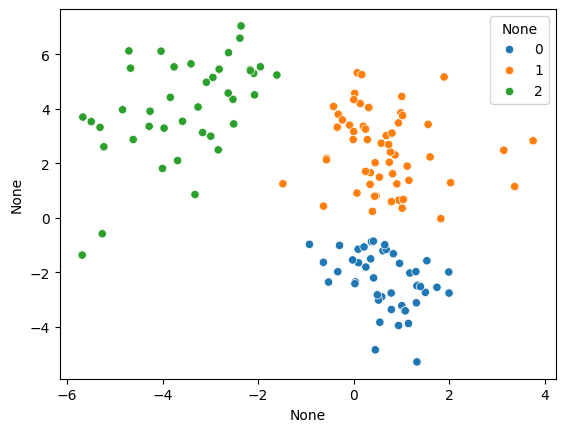

In [292]:
sns.scatterplot(x=X_red_train[:, 0], y=X_red_train[:, 1], hue=y_pred_train, palette='tab10')

### Data Loading and Preprocessing

- Load and preprocess data from a popular dataset
- Use PyTorch's data utilities (e.g., `DataLoader`, `TensorDataset`)

In [303]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### PyTorch Hooks

- Implement custom forward and backward hooks for model introspection and modification

### Build a Transformer from Scratch

- Implement the Transformer architecture from scratch for a task like machine translation

### Training a Transformer